In [41]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [42]:
def DataFrame(path):
    images = []
    labels = []
    for subfolder in os.listdir(path):
        subfolder_path = os.path.join(path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_filename)
            images.append(image_path)
            labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df
train_df=DataFrame('data/Training')
train_df

test_df=DataFrame('data/Testing/')
test_df

,image,label
0,data/Testing/meningioma/Te-me_0106.jpg,meningioma
1,data/Testing/meningioma/Te-me_0192.jpg,meningioma
2,data/Testing/meningioma/Te-me_0217.jpg,meningioma
3,data/Testing/meningioma/Te-me_0190.jpg,meningioma
4,data/Testing/meningioma/Te-meTr_0007.jpg,meningioma
...,...,...
1306,data/Testing/glioma/Te-gl_0134.jpg,glioma
1307,data/Testing/glioma/Te-gl_0060.jpg,glioma
1308,data/Testing/glioma/Te-gl_0054.jpg,glioma
1309,data/Testing/glioma/Te-gl_0281.jpg,glioma


In [43]:
# Initial settings 
# Here you define parameters such as the batch size, the target size of the images, 
# the split ratio for the validation set, and a seed for reproducibility.
batch_size = 32
validation_split = 0.2
target_size = (224, 224)
train_directory = 'data/Training'
test_directory = 'data/Testing'

# This section defines the transforms that will be applied to the images.
# transforms.Resize resizes images to the target size, 
# and transforms.ToTensor converts images to PyTorch tensors.
transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
])

In [44]:
# Esta línea carga los datos de entrenamiento usando ImageFolder, 
# que automáticamente asigna etiquetas a las imágenes basadas en la estructura de directorios. 
# Aplica las transformaciones definidas anteriormente.
full_train_dataset = datasets.ImageFolder(root=train_directory, transform=transform)

# This line loads the training data using ImageFolder, 
# which automatically assigns labels to the images based on the directory structure. 
# Applies the transformations defined above.
train_size = int((1 - validation_split) * len(full_train_dataset))
validation_size = len(full_train_dataset) - train_size
train_dataset, validation_dataset = random_split(full_train_dataset, [train_size, validation_size])

test_dataset = datasets.ImageFolder(root=test_directory, transform=transform)

#Finally, these lines create DataLoaders for training, validation and test sets.
# # DataLoader is a class that provides batches of data, and can optionally shuffle the data (which is useful for the training set).
# # (which is useful for the training set). Each of these parts plays a crucial role in preparing # and handling the data for training. 
# and handling of the data for training and evaluating deep learning models in PyTorch.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [45]:
# The classes are the subdirectories of each data directory to be trained, each one being a category.
class_names = full_train_dataset.classes
print(class_names)

['glioma', 'healthy', 'meningioma', 'pituitary']


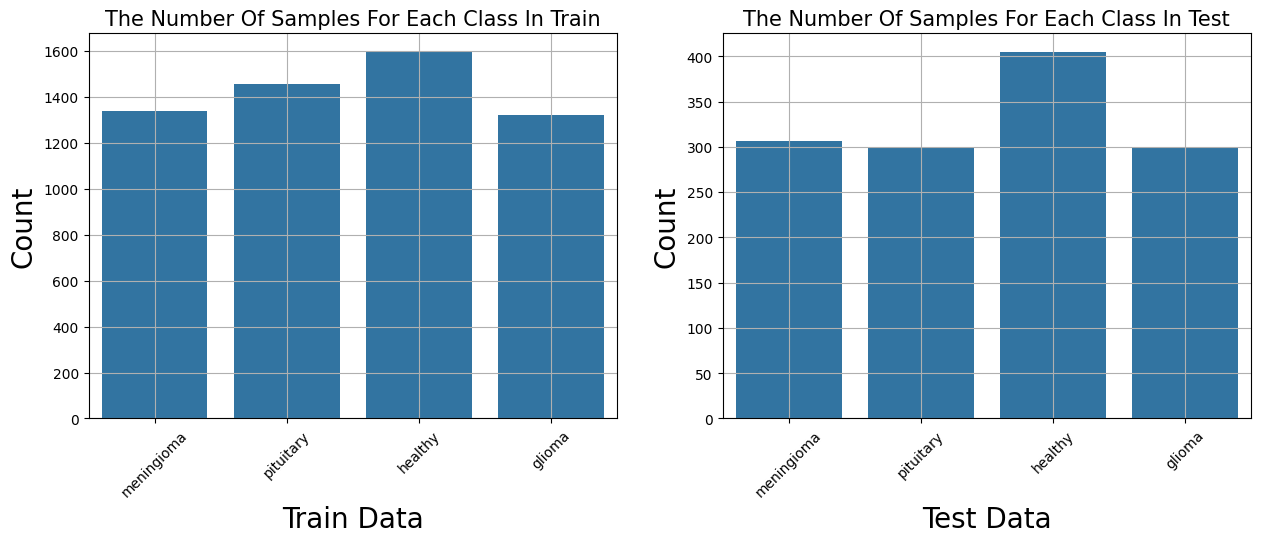

In [46]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(x=train_df.label)
plt.xlabel("Train Data",fontsize=20)
plt.title("The Number Of Samples For Each Class In Train",fontsize=15)
plt.ylabel('Count',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.subplot(1,2,2)
sns.countplot(x=test_df.label)
plt.xlabel("Test Data",fontsize=20)
plt.title("The Number Of Samples For Each Class In Test",fontsize=15)
plt.ylabel('Count',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

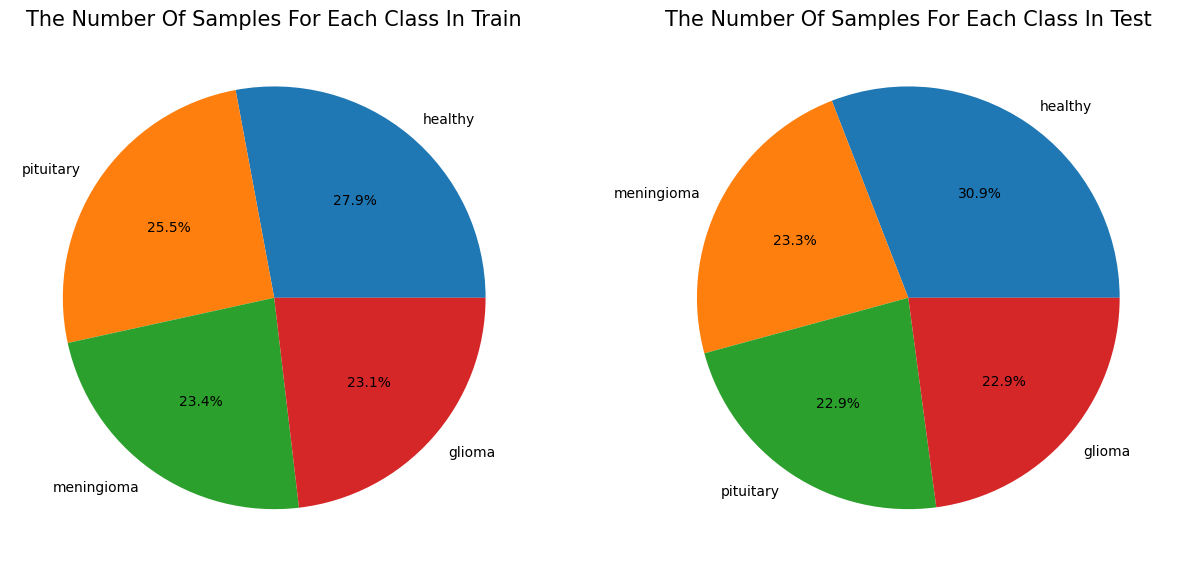

In [47]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.pie(train_df.label.value_counts(),labels=train_df.label.value_counts().index,autopct ='%1.1f%%')
plt.title("The Number Of Samples For Each Class In Train",fontsize=15)
plt.subplot(1,2,2)
plt.pie(test_df.label.value_counts(),labels=test_df.label.value_counts().index,autopct ='%1.1f%%')
plt.title("The Number Of Samples For Each Class In Test",fontsize=15)
plt.show()

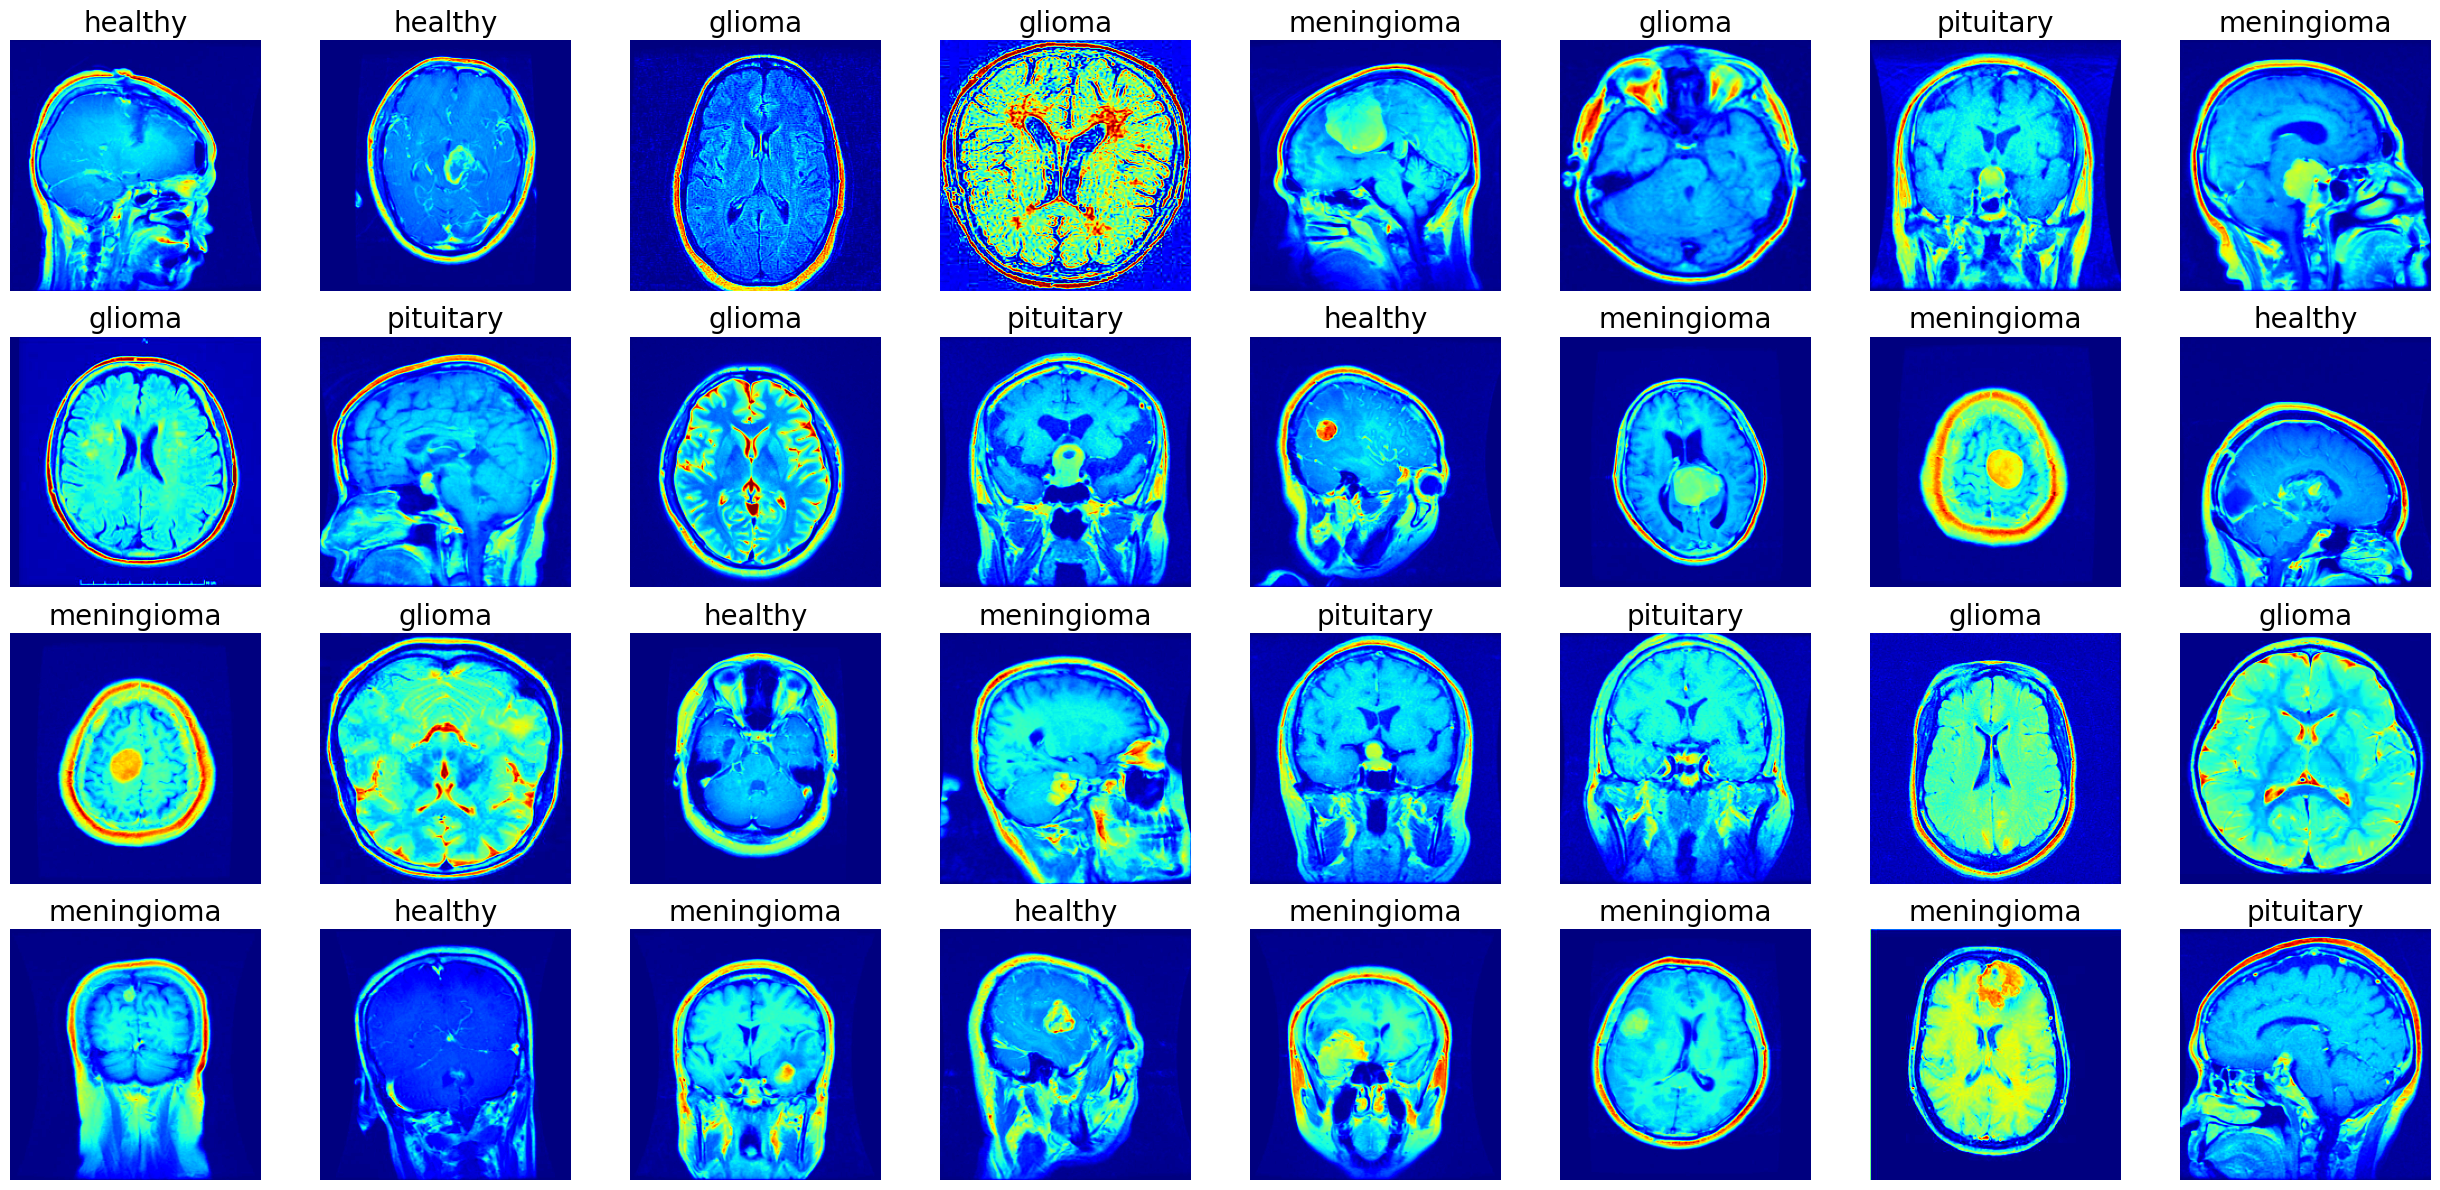

In [48]:
class_names = ['healthy', 'glioma', 'meningioma', 'pituitary']

images, labels = next(iter(train_loader))

images_per_row = 8

number_of_images = len(images)
rows = number_of_images // images_per_row
rows += 0 if number_of_images % images_per_row == 0 else 1  # Add a row if there is a remainder

# Create a new figure with subplots
plt.figure(figsize=(25, 3 * rows))

for i in range(number_of_images):
    ax = plt.subplot(rows, images_per_row, i + 1)
    img = images[i].numpy().transpose((1, 2, 0))
    
    
    img = img.squeeze()
    
    plt.imshow(img, cmap='jet')
    plt.title(class_names[labels[i]], fontsize=20)
    plt.axis('off')

plt.tight_layout()
plt.show()

